# Decision Trees 

## 1. Introduction

Sklearn has a very good introduction: http://scikit-learn.org/stable/modules/tree.html

#### Decision trees are a non-parametric supervised learning method used for classification and regression.
Classification And Regression Tree (CART) analysis is an umbrella term used to refer to both of the above procedures

Advantages:
- simple to understand and interpret
- little data preparation (normalization unnecessary), but need fill in missing values
- numerical + categorical inputs are both fine; multiple outputs

Disadvantages:
- over-fitting; regularization using min_samples_split(split, can create small leaves), min_samples_leaf, or max_depth
- single tree is unstable;
- need to balance the dataset (sample_weight, and hence min_weight_fraction_leaf); otherwise biased;

Time: O(n_samples n_features log(n_samples)) to train; O(log(n_samples)) to test

### some terminologies


[diagram](Data/TreeDiagram.png)

- Root Node: It represents entire population or sample and this further gets divided into two or more homogeneous sets.
- Splitting: It is a process of dividing a node into two or more sub-nodes.
- Decision Node: When a sub-node splits into further sub-nodes, then it is called decision node.
- **Leaf**/ Terminal Node: Nodes do not split is called Leaf or Terminal node.
- Pruning: When we remove sub-nodes of a decision node, this process is called pruning. You can say opposite process of splitting.
- Branch / Sub-Tree: A sub section of entire tree is called branch or sub-tree.
- Parent and Child Node: A node, which is divided into sub-nodes is called parent node of sub-nodes where as sub-nodes are the child of parent node.

### Metrics for classification:

See: http://scikit-learn.org/stable/modules/tree.html#classification-criteria

- These generally measure the homogeneity of the target variable within the subsets.
- Gini impurity: $I(p) = \sum_i^J p_i \sum_{k != i} p_k = \sum_i^J p_i (1 - p_i) = 1 - \sum_i^J p_i^2$
, for J different classes, and $p_i$ is the fraction of items labeled with class i. 
    - how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.
- Cross entropy: $C(p) = - \sum_i^J p_i \log_2(p_i)$; 
    - Information gain is defined as the entropy of the parent subtracting the weighted sum of the entropy of the children
    - Information gain is used to decide which feature to split on at each step in building the tree
- Misclassification: $M(p) = 1 - max(p_i)$

Metrics for Regression: http://scikit-learn.org/stable/modules/tree.html#regression-criteria
- Mean squared error
- Mean absolute error

It only matters in 2% of the cases whether you use gini impurity or entropy.
Entropy might be a little slower to compute (because it makes use of the logarithm).

### Parameters

- Minimum samples for a node split
    - Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
    - Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
    - Too high values can lead to under-fitting hence, it should be tuned using CV.
- Minimum samples for a terminal node (leaf)
    - Defines the minimum samples (or observations) required in a terminal node or leaf.
    - Used to control over-fitting similar to min_samples_split.
    - Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.
- Maximum depth of tree (vertical depth)
    - The maximum depth of a tree.
    - Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    - Should be tuned using CV.
- Maximum number of terminal nodes
    - The maximum number of terminal nodes or leaves in a tree.
    - Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
- Maximum features to consider for split
    - The number of features to consider while searching for a best split. These will be randomly selected.
    - As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.
    - Higher values can lead to over-fitting but depends on case to case.


In [1]:
import matplotlib.pyplot as plt
import seaborn

from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

%matplotlib inline

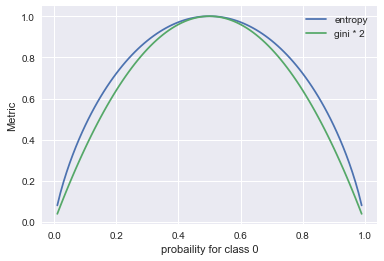

In [2]:
plt.clf()
x = np.linspace(0.01, 0.99, 99)
plt.plot(x, -x*np.log2(x) + -(1 - x)*np.log2(1 - x), label='entropy')
plt.plot(x, (1-x**2-(1-x)**2) * 2, label='gini * 2')
plt.xlabel("probaility for class 0")
plt.ylabel("Metric")
plt.legend()
plt.show()

## 2. How to write a tree from sctrach

https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

In [3]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [4]:
# Select the best split point for a dataset
def get_split(dataset):
    ## last row is y
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    ## loop through each feature
    for index in range(len(dataset[0])-1):
        ## loop through each event
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini   = gini_index(groups, class_values)
            ## update if the new gini score is smaller
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [5]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    '''feature, cutvalue, data'''
    left, right = list(), list()
    for row in dataset: ## for each event;
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [6]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group; 
    #     effectively, the purity of classes in each group
    gini = 0.0
    ## ce   = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        ## score_ce = 0.0
        # save y classes
        p_y = [row[-1] for row in group]
        # score the group based on the score for each class
        for class_val in classes:
            p = p_y.count(class_val) / size
            score += p * p
            ## score_ce += p * np.log2(p) if p != 0 else 0
        # weight the group score by its relative size
        # if score = 1, means all the cases in the node fall into a single category
        gini += (1.0 - score) * (size / n_instances)
        ## ce   += - score_ce * (size / n_instances)
    return gini

In [7]:
# Create child splits for a node or make terminal, recursively
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [8]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [9]:
# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [10]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [11]:
### Test on stupid data
#datastupid = [[-1, -1, 0], [-1, 1, 0], [1, -1, 1], [1, 1, 1]]
#datastupid = [[-1, -1, 0], [-1, 1, 1], [1, -1, 0], [1, 1, 1]]
## doesn't work for decision tree! need a non-linear term
datastupid = [[-1, -1, 1], [-1, 1, 0], [1, -1, 0], [1, 1, 1]] 
treetupid = build_tree(datastupid, max_depth=3, min_size=1)
print_tree(treetupid)
for sample in [[-1, -1], [-1, 1], [1, -1], [1, 1]]:
    print(predict(treetupid, sample))

[X1 < -1.000]
 [0]
 [0]
0
0
0
0


### Let's test the tree building part on some test data

In [12]:
dataset = make_moons(noise=0.1, random_state=0, n_samples=200)
#dataset = make_circles(noise=0.1, random_state=0, n_samples=200)
#dataset = make_classification(random_state=0, n_samples=200)
X, y = dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

## Train the tree
treetrain = np.concatenate((X_train, y_train.reshape(y_train.shape[0], 1)), axis=1)
treetest = np.concatenate((X_test, y_test.reshape(y_test.shape[0], 1)), axis=1)
tree = build_tree(treetrain, 2, 1)
print_tree(tree)

[X2 < 0.051]
 [X1 < 0.057]
  [0.0]
  [1.0]
 [X1 < 1.708]
  [0.0]
  [1.0]


#### Important result: Decision Boundaries of decision trees are always perpendicular to X and Y axis.

             precision    recall  f1-score   support

          0       0.86      0.96      0.91        46
          1       0.93      0.79      0.86        34

avg / total       0.89      0.89      0.89        80



<Figure size 432x288 with 0 Axes>

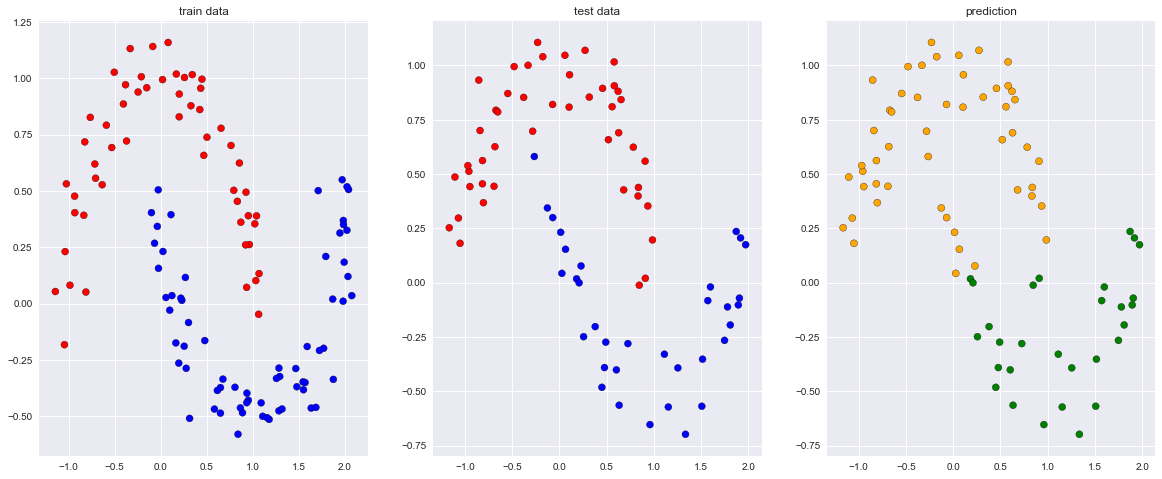

In [13]:
y_pred = []
for row in treetest:
    prediction = predict(tree, row)
    y_pred.append(prediction)
    #print('Expected=%d, Got=%d' % (row[-1], prediction))
print(metrics.classification_report(y_test, y_pred))

## plotting part
plt.clf()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm_predict = ListedColormap(['#FFA500', '#008000'])
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 3, 1)
ax.set_title("train data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
ax = plt.subplot(1, 3, 2)
ax.set_title("test data")
# Plot the training points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k')
ax = plt.subplot(1, 3, 3)
ax.set_title("prediction")
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=cm_predict, edgecolors='k')
plt.show()

## 3. Ensembles and real life

Some techniques, often called ensemble methods, construct more than one decision tree:

**Boosted trees**; Incrementally building an ensemble by training each new instance to emphasize the training instances previously mis-modeled. A typical example is AdaBoost. These can be used for regression-type and classification-type problems.
- **decreases the bias of the model**
- Given many trees, at each boosting step, a new tree is created such that the total training error is minimized.
- Defult boosting method: the first tree in boosted trees works on the original data with equal weights, whereas all the rest work on modified version of the data (as they have different weights, not different contents).
- [Adaboost](https://towardsdatascience.com/boosting-algorithm-adaboost-b6737a9ee60c): 
    - up-weighting observations that were misclassified; up-weighting here means up-weighting data, so next iteration, the tree will try to classify the misclassified event more given they have larger weights!
    - give each tree a different weight such that the correct classifications have higher weights.
    - uses exponential loss function and binary (-1, 1) classifications
- [GBM](https://towardsdatascience.com/boosting-algorithm-gbm-97737c63daa3): Gradient boosting machine
    - At each iteration, a regression tree model is fitted to predict the negative gradient.
    - Update with learning rate, direction, and a step length that can be different for each region
- [Xgboost](https://towardsdatascience.com/boosting-algorithm-xgboost-4d9ec0207d): identifies difficult observations by large residuals; 
    - XGBoost tries to determine the step length, by taking the second derivative; (Newton's method)
    - XGboost can act effectively as a random forest, if specified subsample size and sub-feature sizes;
    - XGboost has parallel when forming each tree;
    - XGboost does regularization;
    - XGboost does pruning: which means at each split it may not be greedy -- it can split even when the step information gain is negative, but the next step's information gain is a larger positive
    
**Bootstrap aggregated (or bagged) decision trees**, an early ensemble method, builds multiple decision trees by repeatedly re-sampling training data with replacement, and voting the trees for a consensus prediction. A random forest classifier is a specific type of bootstrap aggregating.
- **decreases the variance of the model**
- bootstrap sampling is a way of anti-correlating the trees by showing them different training sets.
- Random forests differ in only one way: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. **RF uses feature bagging**. Effectively, it bags both the sample and the feature!
- Typically, for a classification problem with p features, $\sqrt{p}$ (rounded down) features are used in each split.

Rotation forest - in which every decision tree is trained by first applying principal component analysis (PCA) on a random subset of the input features.

## 4.Other resources

- Test the multiple choice questions in: https://vitalflux.com/decision-tree-algorithm-concepts-interview-questions-set-1/

- Tree introcution: https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/

- XGboost introduction (This is still the best resource): https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

- MIT tree: https://ocw.mit.edu/courses/sloan-school-of-management/15-097-prediction-machine-learning-and-statistics-spring-2012/lecture-notes/MIT15_097S12_lec08.pdf

- Intro to boosted trees: https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf

**Finally, if you are ready, please go to these questions, they are really good and require a very good understanding of the decision trees.**

https://www.analyticsvidhya.com/blog/2016/12/detailed-solutions-for-skilltest-tree-based-algorithms/

### Random facts

- The process of top-down induction of decision trees (TDIDT) is an example of a greedy algorithm
- A node can be split on a feature, as long as it gives information after split. So even though the above split does not reduce the classification error.
- Bagged trees uses all the columns for only a sample of the rows. 
- Boosted algorithms minimize error in previously predicted values by last estimator. So it always decreases training error.
- Only Random Forest and XGBoost have parallel implementations. Random Forest is very easy to parallelize, where as XGBoost can have partially parallel implementation. In Random Forest, all trees grows parallel and finally ensemble the output of each tree . Xgboost doesn’t run multiple trees in parallel like Random Forest, you need predictions after each tree to update gradients. Rather it does the parallelization WITHIN a single tree to create branches independently.
- Generally speaking, Boosting algorithms will perform better than bagging algorithms. In terms of bagging vs random forest, random forest works better in practice because random forest has less correlated trees compared to bagging. And it’s always true that ensembles of algorithms are better than single models
- Decision tree recursively uses all the features at each node.
- Random search randomly picks out hyperparameters. In terms of time required, random search requires much less time to converge. Grid search deterministically tries to find optimum hyperparameters. This is a brute force approach for solving a problem, and requires much time to give output.
- It is generally seen that smaller learning rates require more trees to be added to the model and vice versa.
- Maximum possible depth of a tree is only limited by the number of samples, not the number of features.


## Visualising a tree

see: https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084

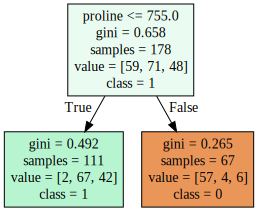

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
# load dataset
data = load_wine()
# feature matrix
X = data.data
# target vector
y = data.target
# class labels
labels = data.feature_names
def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = DecisionTreeClassifier(random_state = 0 , criterion = crit
          , splitter = split
          , max_depth = depth
          , min_samples_split=min_split
          , min_samples_leaf=min_leaf)
    estimator.fit(X, y)
    graph = Source(tree.export_graphviz(estimator
          , out_file=None
          , feature_names=labels
          , class_names=['0', '1', '2']
          , filled = True))

    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[1,2,3,4]
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))
display(inter)